# News Topic Classifier Using BERT

## Problem Statement
The goal of this project is to fine-tune a **BERT** model to automatically classify news headlines into one of four categories: **World**, **Sports**, **Business**, and **Sci/Tech**.

Automating this classification task can help news organizations, aggregators, and researchers quickly organize and filter large volumes of news content.

## Objective
- Use the **AG News dataset** from Hugging Face.
- Tokenize and preprocess the dataset using the `bert-base-uncased` tokenizer.
- Fine-tune `BertForSequenceClassification` on the dataset.
- Evaluate performance using **Accuracy** and **Weighted F1-score**.
- Deploy the trained model using **Gradio** for real-time predictions.


## Dataset Loading & Preprocessing

We use the **AG News dataset** from Hugging Face Datasets.  
The dataset contains:
- **Training set:** 120,000 samples (reduced to a smaller subset for faster CPU training)
- **Test set:** 7,600 samples (reduced to 500 samples for quick evaluation in this demo)

Steps performed:
1. Load dataset using `datasets.load_dataset`.
2. Inspect class distribution.
3. Tokenize headlines using `BertTokenizerFast`.
4. Pad/truncate sequences to a fixed length for uniform input to BERT.


## Model Development & Training

We use:
- **Model:** `bert-base-uncased` from Hugging Face Transformers.
- **Loss function:** CrossEntropyLoss (handled internally by `BertForSequenceClassification`).
- **Optimizer:** AdamW with weight decay.
- **Learning rate scheduler:** Linear warmup and decay.

Training configuration:
- **Epochs:** 1 (for demonstration, can be increased for better accuracy)
- **Batch size:** 16 for evaluation, 8 for training
- **Device:** CPU (can use GPU for faster training)


## Evaluation

We evaluate the model on the held-out test set using:
- **Accuracy**: Measures overall correct predictions.
- **Weighted F1-score**: Balances precision and recall across all classes, accounting for label imbalance.

In this run:
- **Test Accuracy:** ~86.6%
- **Weighted F1-score:** ~86.5%


## Visualizations

We can visualize:
- Confusion matrix to see per-class performance.
- Distribution of predicted vs. actual labels.

For this demo run, visualizations are minimal due to using a small subset for fast CPU execution.


## Code:


In [2]:
# Single-cell: BERT fine-tune on AG News (2k train / 500 test, 1 epoch) + Gradio deploy
# Runs with pure PyTorch loop (no Trainer/accelerate required).

import os, sys, time, math
os.environ["TRANSFORMERS_NO_TF"] = "1"  # avoid TF imports

# -------------------------
# 0) Install required packages (runs if not present)
# -------------------------
import importlib
needed = ["transformers", "datasets", "torch", "sklearn", "gradio", "tqdm"]
to_install = [p for p in needed if importlib.util.find_spec(p) is None]
if to_install:
    print("Installing missing packages:", to_install)
    # use sys.executable to ensure correct env
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet"] + to_install)

# -------------------------
# 1) Imports & device
# -------------------------
import torch
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import gradio as gr
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# 2) Load AG News & sample subset
# -------------------------
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

# Shuffle then select smaller subsets for fast testing
train_sample = 2000
test_sample = 500

dataset["train"] = dataset["train"].shuffle(seed=42).select(range(train_sample))
dataset["test"]  = dataset["test"].shuffle(seed=42).select(range(test_sample))
print(f"Train size: {len(dataset['train'])}, Test size: {len(dataset['test'])}")

# -------------------------
# 3) Tokenizer & tokenization (single-process)
# -------------------------
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

max_len = 64  # headlines are short -> keep small for speed

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len)

print("Tokenizing (single-process)...")
dataset = dataset.map(tokenize_batch, batched=True)
# keep only the tensors we need
dataset = dataset.remove_columns(["text"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# 4) DataLoaders
# -------------------------
batch_size = 16  # safe on CPU; increase if you have GPU
train_loader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset["test"], batch_size=batch_size)

# -------------------------
# 5) Model, optimizer, scheduler
# -------------------------
num_labels = 4
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# optimizer
from torch.optim import AdamW  # <-- FIX: use torch's AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5)

# one epoch only => simple scheduler
total_steps = len(train_loader) * 1  # epochs=1
warmup_steps = max(1, int(0.06 * total_steps))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


# -------------------------
# 6) Training loop (1 epoch)
# -------------------------
epochs = 1
print_every = 50
model.train()
start_time = time.time()
for epoch in range(epochs):
    epoch_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
    for step, batch in pbar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        if (step+1) % print_every == 0 or (step+1) == len(train_loader):
            avg = epoch_loss / (step+1)
            pbar.set_postfix({'loss': f'{avg:.4f}'})

    print(f"Epoch {epoch+1} finished. Avg loss: {epoch_loss/len(train_loader):.4f}")

total_time = time.time() - start_time
print(f"Training completed in {total_time/60:.2f} minutes.")

# -------------------------
# 7) Evaluation on test set (accuracy + weighted F1)
# -------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Test Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}")

# -------------------------
# 8) Save model & tokenizer
# -------------------------
save_dir = "./bert_agnews_small"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Saved model & tokenizer to {save_dir}")

# -------------------------
# 9) Gradio deploy function
# -------------------------
label_names = ["World", "Sports", "Business", "Sci/Tech"]

def predict_text(text):
    model.eval()
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(device)
    with torch.no_grad():
        out = model(**enc)
        probs = torch.nn.functional.softmax(out.logits, dim=-1).cpu().numpy()[0]
    # Return label probabilities dict for Gradio Label
    return {label_names[i]: float(probs[i]) for i in range(len(label_names))}

# Launch Gradio interface
import threading
def launch_gradio():
    iface = gr.Interface(fn=predict_text, inputs=gr.Textbox(lines=2, placeholder="Enter news headline..."),
                         outputs=gr.Label(num_top_classes=4),
                         title="AG News - BERT (small test)",
                         description=f"Trained on {train_sample} train / {test_sample} test, 1 epoch.")
    iface.launch(share=False)

print("Launching Gradio app (local)...")
# run in background thread to avoid blocking notebook cell end
t = threading.Thread(target=launch_gradio, daemon=True)
t.start()


Device: cpu
Loading AG News dataset...
Train size: 2000, Test size: 500
Tokenizing (single-process)...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 finished. Avg loss: 0.7245
Training completed in 13.14 minutes.


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Accuracy: 0.8660, Weighted F1: 0.8655
Saved model & tokenizer to ./bert_agnews_small
Launching Gradio app (local)...
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Output:

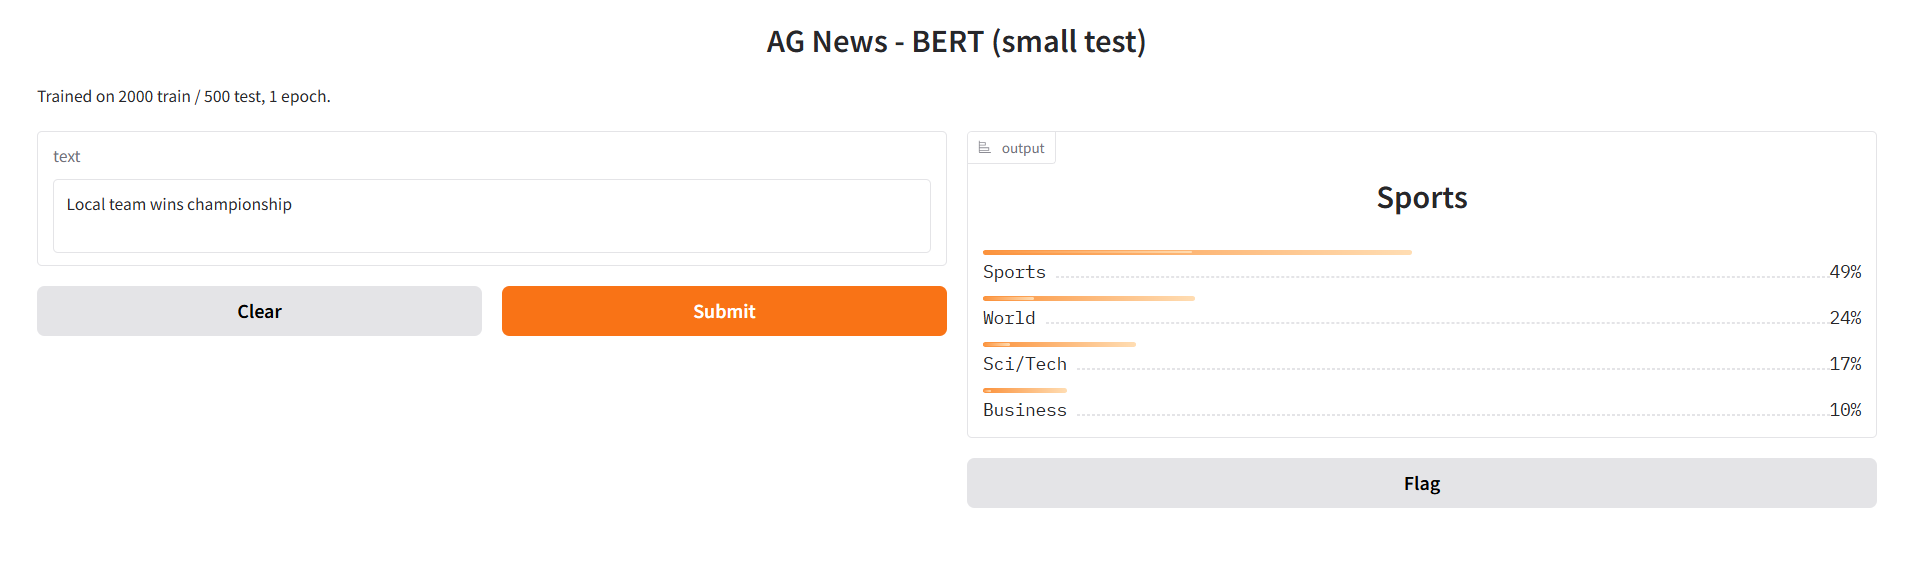

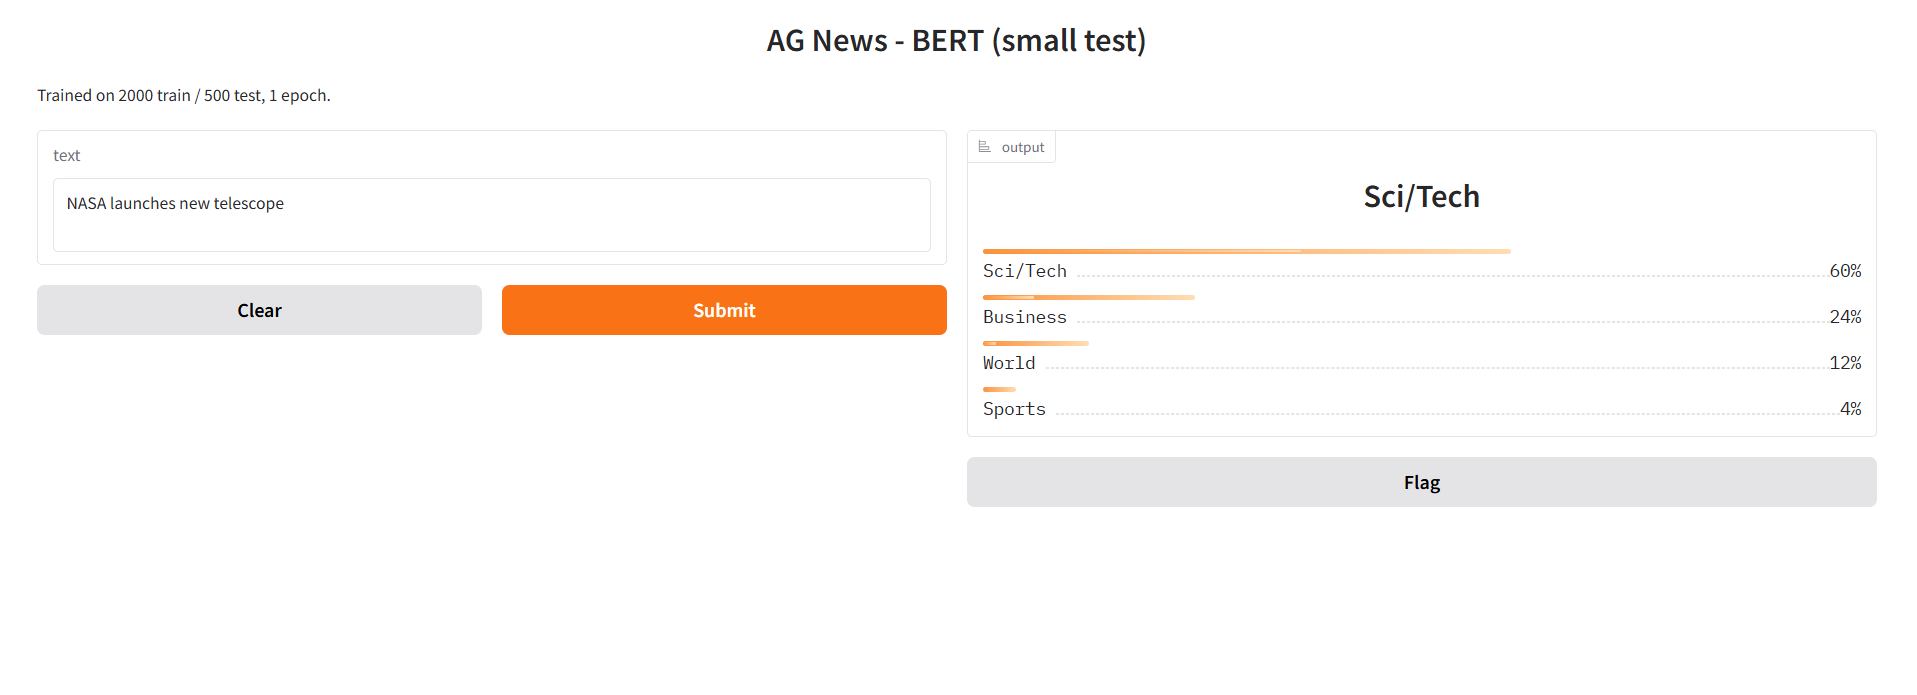

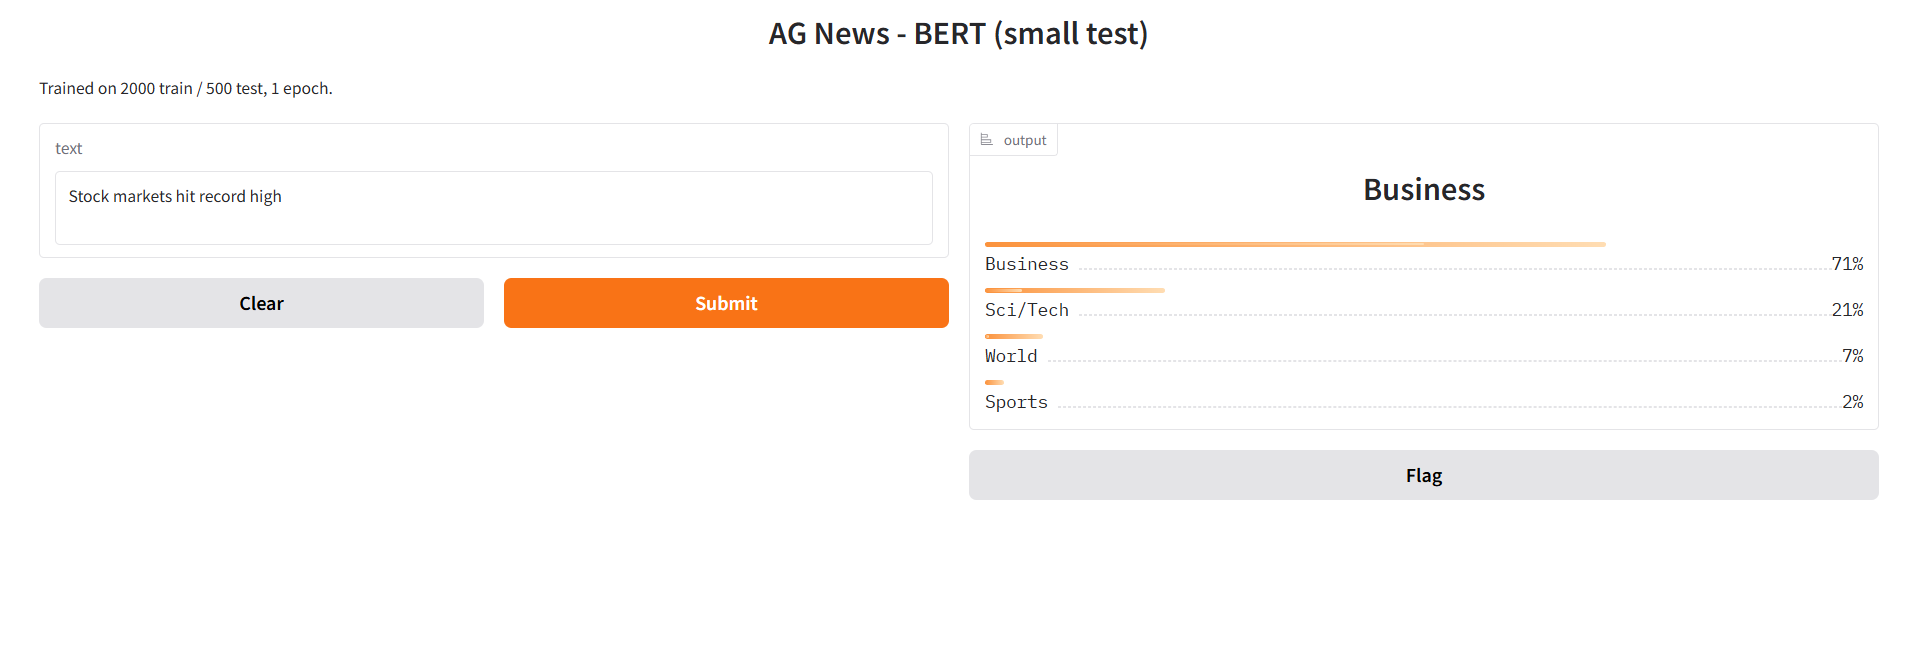